
# Problem Statement
* Create a dataset loader for the IMDB reviews dataset here (You will need to write some python code to download and extract it in your notebook!). Use it to load the training/testing set, and break reviews up by words. (i.e., "This movie was terrible!" -> ["this", "movie", "was", "terrible"] -> torch.tensor([1, 8, 2, 9])

* Train some form of RNN model on the dataset. Its up to you to select the type, single-bidirectional, number of layers, etc. Explain your choices and show the comparisons that lead you to your conclusions! If you need to down sample the training set to make training faster, that is OK. Just explain why!

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from nltk.corpus import stopwords
import nltk
import glob
import itertools
import string

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Extracting the required data from source URL using requests and tarfile libraries.

In [0]:
download_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [0]:
import requests, zipfile, io

r = requests.get(download_url)

tar_bytes = io.BytesIO(r.content)

import tarfile

tf = tarfile.open(fileobj=tar_bytes)

tf.extractall()

To get all files in the current directory, we use the glob module. We are looking for all text files with both positive and negative reviews in them and storing them in seperate lists.

In [0]:
train_pos_files=glob.glob("aclImdb/train/pos/*.txt")
train_neg_files=glob.glob("aclImdb/train/neg/*.txt")
test_pos_files=glob.glob("aclImdb/test/pos/*.txt")
test_neg_files=glob.glob("aclImdb/test/neg/*.txt")

I opened each file, read the content in them and appended the content to an empty list. As a result, we have 4 lists with 12500 reviews each as list of lists.

Ex: train_pos_list=[['this is a good movie'],['Dicaprio was excellent'],....]

In [0]:
train_pos_list=[]
train_neg_list=[]
test_pos_list=[]
test_neg_list=[]
for files in train_pos_files:
  with open(files,'r') as temp:
    train_pos= temp.read().replace('\n','')
    train_pos_list.append(train_pos)
for files in train_neg_files:
  with open(files,'r') as temp:
    train_neg= temp.read().replace('\n','')
    train_neg_list.append(train_neg)
for files in test_pos_files:
  with open(files,'r') as temp:
    test_pos= temp.read().replace('\n','')
    test_pos_list.append(test_pos)
for files in test_neg_files:
  with open(files,'r') as temp:
    test_neg= temp.read().replace('\n','')
    test_neg_list.append(test_neg)


Now, to clean the sentences(reviews) I imported the nltk module to remove stopwords and punctuations from each review.To create a dictionary, we need to make sure we have unique words that actually reflect a review as positive or negative.

In [0]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
punctuation = ".,:;!?<>'{\}/" "`~@#$%^&*()_-+=)"
vague_words=['br']

def remove_punctuation(input_string):
  for item in punctuation:
    input_string = input_string.replace(item, '')
  return input_string

def remove_vague_words(input_string):
  for item in vague_words:
    input_string= input_string.replace(item, '')
  return input_string



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I created a function to perform the cleaning tasks. The function takes a sentence as input and returns individual words after removing stopwords,punctuations,converting them to lower case and then splitting the sentence.
Using list comprehension, I got all words that do not exist in stopwords, removed empty spaces and finally returned the cleaned word.

In [0]:
def sent_to_word(newline):
  temp_list=[]
  newline= newline.translate(str.maketrans("", "", string.punctuation))
  newline = remove_punctuation(sent)
  newline = remove_vague_words(newline)
  newline = newline.lower()
  tokens= newline.split(' ')
  k = [word for word in tokens if word not in stop_words]
  while '' in k:
    k.remove('')
  temp_list.append(k)
  return k

  

I created empty lists to append the transformed review containing the clean words after calling the previously defined sent_to_word function.

In [0]:
tr_train_pos_list=[]
tr_train_neg_list=[]
tr_test_pos_list=[]
tr_test_neg_list=[]
for sent in train_pos_list:
  tr_train_pos_list.append(sent_to_word(sent))
for sent in train_neg_list:
  tr_train_neg_list.append(sent_to_word(sent))
for sent in test_pos_list:
  tr_test_pos_list.append(sent_to_word(sent))
for sent in test_neg_list:
  tr_test_neg_list.append(sent_to_word(sent))

Since we need a common vocabulary of words for both our training and testing data, we need a list of total unique words present in our data. Hence, I converted my list of lists containing reviews in words into a single list of all words in that list with repitition.

Ex: a=[['good','movie'],['excellent','screenplay']] ==> b=['good','movie','excellent','screenplay']

To do this, I merged my list of lists using the following lines of code.

In [0]:
merged_train_pos = list(itertools.chain(*tr_train_pos_list))
merged_train_neg = list(itertools.chain(*tr_train_neg_list))
merged_test_pos = list(itertools.chain(*tr_test_pos_list))
merged_test_neg = list(itertools.chain(*tr_test_neg_list))

I combined all the 4 lists into a single list containing all the words in our data.

In [0]:
merged=[]
merged= list(itertools.chain(*tr_train_pos_list)) + list(itertools.chain(*tr_train_neg_list)) + list(itertools.chain(*tr_test_pos_list)) + list(itertools.chain(*tr_test_neg_list))

Finally, I found unique words in our data. If a word from the combined list did not exist in an empty list, we append it to the new list.

In [0]:
unique_words=[]
for word in merged:
  if word not in unique_words:
    unique_words.append(word)

The total number of unique words in the data is 191767.

In [0]:
len(unique_words)

191767

To create a dictionary, I used this function from https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html 

In [0]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "pad", 1: "sos", 2: "eos"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

I created a vocabulary. Our data that needs to be fed into vocabulary is the unique words list.

In [0]:
voc = Vocabulary('test')
corpus= unique_words

Now, we populate our dictionary by using the add_word pre-defined function to add each word of the unique_list into the dictionary.

In [0]:
for word in corpus:
  voc.add_word(word)

Now, I created two individual list: One for all the unique words(tokens), the other for their corresponding unique indexes. I created indexes using the to_index() pre-defined function.

In [0]:
sent_tkns = []
sent_idxs = []
for word in corpus:
  sent_tkns.append(word)
  sent_idxs.append(voc.to_index(word))

To create a dictionary from a pair of lists, I used the zip function.

In [0]:
dictionary=dict(zip(sent_tkns,sent_idxs))

In [0]:
len(dictionary)

191767

Now, we have our dictionary established with each word in the data having a unique index to it. Now, let us convert each review with words into tensors by inferencing this dictionary to obtain the index of each word.

For example:

A review has the words: ['The','movie','was','bad']. We want to convert this into [76,55,22,11] by giving a dictionary key input which will return an integer value. This numpy array is then converted into tensors using torch.tensor command.

In [0]:
def word_to_vec(data):
  X=[]
  for review in data:
    Y=[]
    for word in review:
      Y.append(dictionary[word])
    X.append(torch.tensor(Y))
  return X



In [0]:
tr_train_pos_list= word_to_vec(tr_train_pos_list)
tr_train_neg_list= word_to_vec(tr_train_neg_list)
tr_test_pos_list= word_to_vec(tr_test_pos_list)
tr_test_neg_list= word_to_vec(tr_test_neg_list)

For ease of use and reducing the run time, I sampled the data to half its value.

In [0]:
tr_train_pos_list=tr_train_pos_list[:6250]
tr_train_neg_list=tr_train_neg_list[:6250]
tr_test_pos_list=tr_test_pos_list[:6250]
tr_test_neg_list=tr_test_neg_list[:6250]

Now, we have tensor values for every review but have not labelled our data. To label our reviews as positive and negative, we will choose to label all positive words as 1 and negative words as 0.

So, for every single review in a list of lists, we are adding 1 or 0 depending on the name/type of the list it comes from (positive or negative).

In [0]:
train_data=[]
test_data=[]
for j in range(len(tr_train_pos_list)):
      train_data.append([tr_train_pos_list[j],1])
for j in range(len(tr_train_neg_list)):
      train_data.append([tr_train_neg_list[j],0])
for j in range(len(tr_test_pos_list)):
      test_data.append([tr_test_pos_list[j],1])
for j in range(len(tr_test_neg_list)):
      test_data.append([tr_test_neg_list[j],0])

In [0]:
len(test_data)

12500

Now we have our final training data and testing data to build networks and predict if a review is positive or negative.

From our previous lectures, I imported the train_simple_network function to train our model and keep track of metrics that can help us determine how our model is performing.

In [0]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

From the previous lecture, I imported the LastTimeStep class.

In [0]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tyuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

Embedding in RNN is slightly similar to one-hot encoding where an array consists of all zero's except a single 1 which is a vector representation of a feature. But for words in our case, this representation would be too vague as we would like to see how similar two words are depending on their context. In order to have a representation where similar words have smaller euclidean distance than the ones which are not similar at all. Here, similarity is based upon context of the word i.e. what conditions or surroundings is the word used in. This representation is called **word embedding** . 

Hence, using an embedding layer which has a size equal to the vocabulary size of our dataset has become really popular.



In [0]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)

We define our training and testing loader by providing the training and testing data. Initially, I tried using a simple RNN with batch_size=1.

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

D is the number of features, alphabet_size is the length of our dictionary. The number of classes is 2 as we are predicting if a review is positive or negative.

In [0]:
D = 50
alphabet_size = len(dictionary)
hidden_nodes = 100
classes = 2

first_rnn_1 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

first_rnn_1.to('cuda')

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 50)
  )
  (1): RNN(50, 100, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
loss_func = nn.CrossEntropyLoss()

batch_one_train = train_simple_network(first_rnn_1, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=5)

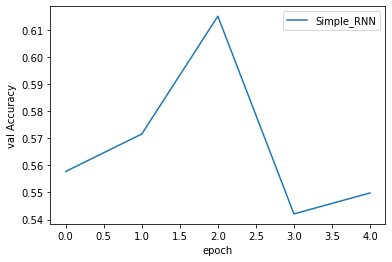

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='Simple_RNN')

The model was able to perform with an accuracy of 61 percent but dropped significantly after just 2 epochs and has not been consistent. Lets try padding and packing the data to increase our batch size and account for variable length of our input lenghts.

In [0]:
def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    longest = max(lengths)
    #We need to pad all the inputs up to 'longest', and combine into a batch ourselves
    if len(input_tensors[0].shape) == 1:
        x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    else:
        raise Exception('Current implementation only supports (T) shaped data')
    
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    
    y_batched = torch.as_tensor(labels, dtype=torch.long)
        
    return x_packed, y_batched


I set the batch size as 50 and declared the collate function to be pad_and_pack.

In [0]:
B=50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=B, shuffle=True,collate_fn=pad_and_pack)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=B, shuffle=False,collate_fn=pad_and_pack)
rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, 2), #(B, D) -> (B, classes)
)

rnn_packed.to('cuda')

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 50)
  )
  (1): RNN(50, 100, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
rnn_packed_results = train_simple_network(rnn_packed, loss_func, train_loader=train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10, lr=0.001)

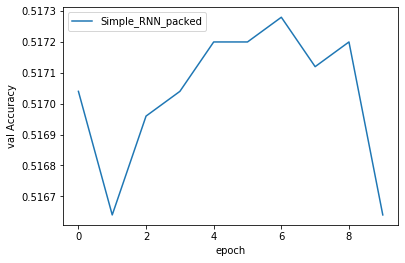

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_packed_results, label='Simple_RNN_packed')

I believe the inconsistency in performance was due to the large batch size. Large batch size means the model makes very large gradient updates and very small gradient updates. But this may not always be the case. A larger batch size "may" improve the effectiveness of the optimization steps resulting in more rapid convergence of the model parameters.
A larger batch size can also improve performance by reducing the communication overhead caused by moving the training data to the GPU. This causes more compute cycles to run on the card with each iteration.


https://www.pugetsystems.com/labs/hpc/GPU-Memory-Size-and-Deep-Learning-Performance-batch-size-12GB-vs-32GB----1080Ti-vs-Titan-V-vs-GV100-1146/

To test if I'm right, I tuned down the batch size to 20 and trained the same network.

In [0]:
B=20
rnn_packed_2 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, 2), #(B, D) -> (B, classes)
)

rnn_packed.to('cuda')

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 50)
  )
  (1): RNN(50, 100, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
rnn_packed_2_results = train_simple_network(rnn_packed_2, loss_func, train_loader=train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10, lr=0.001)

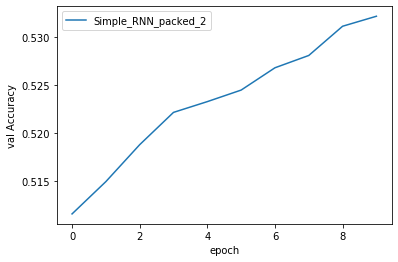

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_packed_2_results, label='Simple_RNN_packed_2')

I believe reducing batch size did help the model learn and perform slightly better. The model was consistent in its performance with increasing and higher accuracy than the previous case.

Now, I tried adding a few extra layers to see how the model would perform.

In [0]:
rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 50)
  )
  (1): RNN(50, 100, num_layers=3, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
rnn_3layer_results = train_simple_network(rnn_3layer, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001)

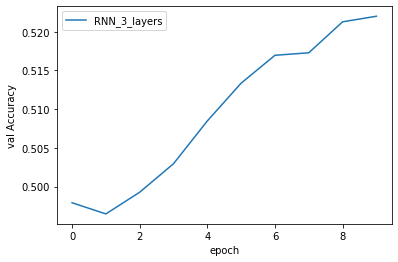

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_results, label='RNN_3_layers')

The model performed at par with the previous model with no significant changes in accuracy. So, I tried the bi-directional next. I tuned down the number of features and hidden nodes to 32 and 64 just to see if it would improve performance.

In [0]:
D=32
hidden_nodes=64
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 32)
  )
  (1): RNN(32, 64, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001*B)

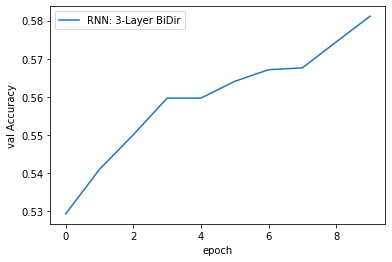

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')

Well, the model did perform better than the previous one. I believe the reason for this improvement is due to its bidirectional structure which allows the networks to have both backward and forward information about the sequence at every time step.

I was curious to see if doubling the number of layers would affect the perfomance of the model.

In [0]:
B=15

rnn_3layer_bidir_2 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=6, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=6, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir_2.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(191767, 32)
  )
  (1): RNN(32, 64, num_layers=6, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
rnn_3layer_bidir_2_results = train_simple_network(rnn_3layer_bidir_2, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001*B)

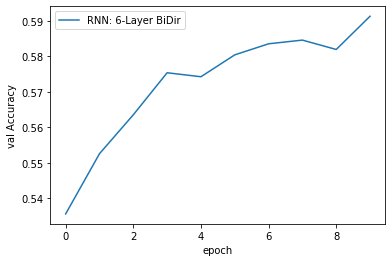

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_2_results, label='RNN: 6-Layer BiDir')

There was no significant change by doubling the layers which prompted me to stay with 3 layers for my future models.

I tried the Long Short Term Memory (LSTM) with bi-directional nature. Bidirectional Recurrent Neural Networks connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past and future states simultaneously.

In [0]:
B=20
lstm = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

lstm.to(device)

lstm_results = train_simple_network(lstm, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001*B)

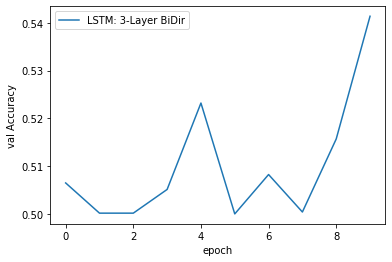

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_results, label='LSTM: 3-Layer BiDir')

But the model was inconsistent and perfomed under par since I expected it to learn from the past and future to predict lables accurately. I played around with a few paramenters to check if it would increase the accuracy.

In [0]:
B=30
lstm_2 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

lstm_2.to(device)

lstm_2_results = train_simple_network(lstm_2, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001)

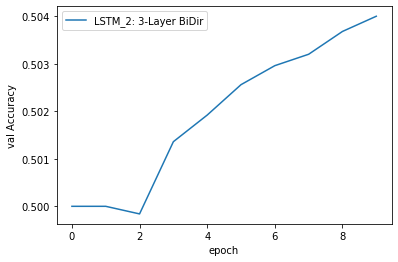

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_2_results, label='LSTM_2: 3-Layer BiDir')

In [0]:
B=15
train_loader = torch.utils.data.DataLoader(train_data, batch_size=B, shuffle=True,collate_fn=pad_and_pack)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=B, shuffle=False,collate_fn=pad_and_pack)

In [0]:
D=32
hidden_layers=64
lstm_3 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

lstm_3.to(device)

lstm_3_results = train_simple_network(lstm_3, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001)

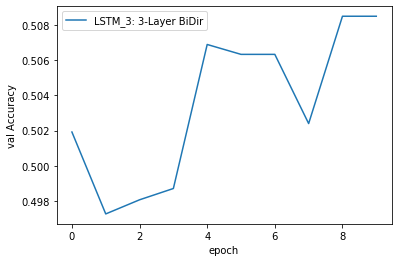

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_3_results, label='LSTM_3: 3-Layer BiDir')

Well, altering the paramenters like batch_size, features and hidden_nodes did'nt have a significant affect on the model's performance. I believe this is due to the amount of data we are using for this analysis. We have sampled the data into half and fed it to the Long Short Term Memory model, not giving it scope to learn, both past and future. I believe giving the model the full data and training it for a higher number of epochs would certainly improve its performance.

I tried using the GRU which is like a long short-term memory (LSTM) with forget gate but has fewer parameters than LSTM, as it lacks an output gate. Hence, its faster to train.

In [0]:
B=10
gru = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.GRU(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

gru.to(device)

gru_results = train_simple_network(gru, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001*B)

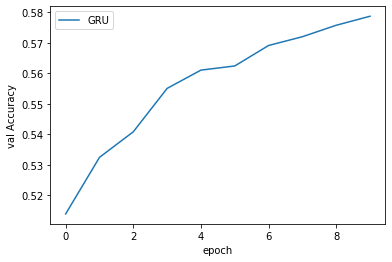

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')

I got similar accuracy as the previous case, but the model performed consistently. Both the LSTM and GRU are similar( except that GRU has no memory unit and exposes the full hidden content without any restrictions) to each other but computationally GRU is more efficient.

I increased the number of features and hidden nodes to check for better performance.

In [0]:
D=60
hidden_nodes=120
gru_3 = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.GRU(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

gru_3.to(device)

gru_3_results = train_simple_network(gru_3, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001*B)

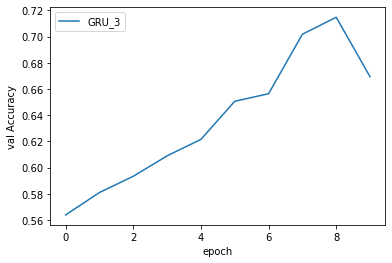

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_3_results, label='GRU_3')

The model had a significant rise in accuracy and achieved peak accuracy faster, around the 8th epoch. This is the best performance any of my models achieved.